In [1]:
import os
import time
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import *
from math import isclose
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

In [2]:
# Read in the dataset images and test images.
car_data = glob.glob('./vehicles/*/*.png')
noncar_data = glob.glob('./non-vehicles/*/*.png')
test_images = glob.glob('./test_images/*.jpg')

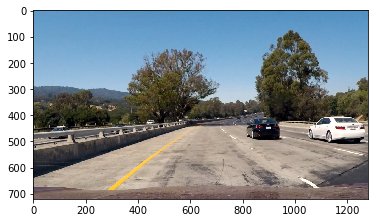

In [372]:
# An example of the test image visualized
example_img = cv2.imread(test_images[0])
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
plt.imshow(example_img)

In [373]:
# Function that reads in a list of bounding boxes and draws them onto the input image.
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    img_draw = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(img_draw, bbox[0], bbox[1], color, thick)
    return img_draw

In [374]:
# A visualizing function to facilitate multiple images visualizations.
def visualize(imgs, rows, cols, titles=None, size=(20,20)):
    fig, axes = plt.subplots(rows, cols, figsize=size)
    i = 0
    for row in range(rows):
        for col in range(cols):
            axes[row][col].axis('off')
            if titles is not None:
                axes[row][col].set_title(titles[i])
            axes[row][col].imshow(imgs[i])
            i+=1
    return fig, axes

In [375]:
# Resize the image channels to specified size and produce a single feature vector.
def spatial_bin(img, size=(32,32)):
    ch1 = cv2.resize(img[:,:,0], size).ravel()
    ch2 = cv2.resize(img[:,:,1], size).ravel()
    ch3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((ch1,ch2,ch3))

In [378]:
print('Number of Spatial Feature\'s Vector: {}'.format(spatial_bin(example_img).shape[0]))

Number of Spatial Feature's Vector: 3072


In [7]:
# Calculate the histogram of each color channel among 32 bins.
def color_hist(img, nbins=32):
    ch1_hist,_ = np.histogram(img[:,:,0], bins=nbins)
    ch2_hist,_ = np.histogram(img[:,:,1], bins=nbins)
    ch3_hist,_ = np.histogram(img[:,:,2], bins=nbins)
    
    color_features = np.hstack((ch1_hist,ch2_hist,ch3_hist))
    return color_features

In [379]:
print('Number of Color Histogram Feature\'s Vector: {}'.format(color_hist(example_img).shape[0]))

Number of Color Histogram Feature's Vector: 96


In [380]:
# Calculate HOG features for a single color channel
def hog_feature(img, orient_bins=9, px_pcell=8, cell_pblock=2, 
                norm='L2-Hys', vis=False, transform=False, feature=True):
    ## The vis parameter allows us to visualize the calculated HOG features in hog_img returned.
    if vis:
        features, hog_img = hog(img, orient_bins, (px_pcell,px_pcell), (cell_pblock,cell_pblock),
                               block_norm=norm, visualise=vis, transform_sqrt=transform, feature_vector=feature)
        return features, hog_img
    else:
        features = hog(img, orient_bins, (px_pcell,px_pcell), (cell_pblock,cell_pblock),
                               block_norm=norm, visualise=vis, transform_sqrt=transform, feature_vector=feature)
        return features

In [381]:
## INPUT IMAGES FILES
# Extract features from 64x64 datasets.
def extract_features(imgs, color_space='RGB',
                     spatial_size=(32,32),
                     color_bins=32,
                     hog_bins=9, px_pcell=8, cell_pblock=2, hog_channel='ALL',
                     spatial_feat=True, color_feat=True, hog_feat=True):
    features = []
    # Read into each file of input array of image files.
    for file in imgs:
        img = cv2.imread(file)
        file_features = []
        # Convert the image into specified color space
        if color_space == 'RGB':
            color_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if color_space == 'YUV':
            color_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        if color_space == 'LUV':
            color_img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        if color_space == 'HSV':
            color_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        if color_space == 'YCrCb':
            color_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        if color_space == 'HLS':
            color_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        
        # 1. Append the Spatially Binned features
        if spatial_feat:
            file_features.append(spatial_bin(color_img, size=spatial_size))
        
        # 2. Append the Color Histograms 
        if color_feat:
            file_features.append(color_hist(color_img, nbins=color_bins))
            
        # 3. Append the HOG features.
        if hog_feat:
            if hog_channel == 'ALL':
            # Calculates the HOG features across all the channels
                hog_channels = []
                for i in range(color_img.shape[2]):
                    hog_channels.append(hog_feature(color_img[:,:,i], orient_bins=hog_bins,
                                                    px_pcell=px_pcell,cell_pblock=cell_pblock))
                file_features.append(np.concatenate(hog_channels))
            else:
            # Calculate the HOG features for only the specified channel
                file_features.append(hog_feature(color_img[:,:,hog_channel], orient_bins=hog_bins,
                                                 px_pcell=px_pcell,cell_pblock=cell_pblock))
        
        # Concatenate the three feature vectors extracted
        features.append(np.concatenate(file_features))
    
    return np.vstack(features).astype(np.float64)

In [382]:
#Set Parameters & Extract Features
color_space = 'YCrCb' 
spatial_size = (32,32)  # spatial_bin() size parameter
color_bins = 32         # color_hist() nbins parameter
hog_bins = 9            # hog_feature() orient_bins parameter
px_pcell=8              # hog_feature() px_pcell parameter
cell_pblock=2           # hog_feature() cell_pblock parameter
hog_channel='ALL'       # hog_feature() hog_channel parameter
spatial_feat=True
color_feat=True 
hog_feat=True

# Extract Car Features
car_features = extract_features(car_data, color_space=color_space,
                                spatial_size=spatial_size, spatial_feat=spatial_feat,
                                color_bins=color_bins, color_feat=color_feat,
                                hog_bins=hog_bins,px_pcell=px_pcell,cell_pblock=cell_pblock,
                                hog_channel=hog_channel, hog_feat=hog_feat)

# Extract NonCar Features
noncar_features = extract_features(noncar_data, color_space=color_space,
                                   spatial_size=spatial_size, spatial_feat=spatial_feat,
                                   color_bins=color_bins, color_feat=color_feat,
                                   hog_bins=hog_bins,px_pcell=px_pcell,cell_pblock=cell_pblock,
                                   hog_channel=hog_channel, hog_feat=hog_feat)

In [360]:
print('Number of Total Features Concatenated: {:,}'.format(car_features.shape[1]))

Number of Total Features Concatenated: 8,460


In [13]:
# Create the Car and Noncar Dataset of Features X and Labels y
car_labels = np.ones(len(car_data))
noncar_labels = np.zeros(len(noncar_data))

y = np.hstack((car_labels,noncar_labels))
X = np.vstack((car_features,noncar_features))

In [14]:
# Scale and Normalize the extracted features
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

In [15]:
# Shuffle and test the data set into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1)

In [16]:
# Linear Support Vector Machine, trained on the Training dataset.
clf = LinearSVC(C=1.)
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [17]:
print('Linear SVM Classifier - Accuracy = {:.2f}%'.format(clf.score(X_test, y_test)*100))

Linear SVM Classifier - Accuracy = 99.10%


In [354]:
print('Car Images in Training dataset: {:.2f}%'.format((len(np.where(y_train==1)[0]) / len(y_train))*100))

Car Images in Training dataset: 49.41%


In [20]:
## INPUT RGB IMAGES
## Vehicle Detecting Function, which involves sliding windows & feature extraction
def detect_vehicle(img, scale, clf, X_scaler,
                   color_space='YCrCb', 
                   yrange=[None,None], xrange=[None,None],
                   spatial_size=spatial_size,
                   color_bins=color_bins,
                   hog_bins=hog_bins, px_pcell=px_pcell, cell_pblock=2):
    
    
    window_points = []
    
    # Define y and x range for a more specified search
    if yrange[0] is None:
        yrange[0] = 0
    if yrange[1] is None:
        yrange[1] = img.shape[0]
        
    if xrange[0] is None:
        xrange[0] = 0
    if xrange[1] is None:
        xrange[1] = img.shape[1]
    
    # Crop Image into Specified Ranges
    search_img = img[yrange[0]:yrange[1],xrange[0]:xrange[1],:]

    # Convert Image's Color Space to the specified color_space parameter
    if color_space != 'RGB':
        if color_space == 'YUV':
            color_search_img = cv2.cvtColor(search_img, cv2.COLOR_RGB2YUV)
        if color_space == 'LUV':
            color_search_img = cv2.cvtColor(search_img, cv2.COLOR_RGB2LUV)
        if color_space == 'HSV':
            color_search_img = cv2.cvtColor(search_img, cv2.COLOR_RGB2HSV)
        if color_space == 'YCrCb':
            color_search_img = cv2.cvtColor(search_img, cv2.COLOR_RGB2YCrCb)
        if color_space == 'HLS':
            color_search_img = cv2.cvtColor(search_img, cv2.COLOR_RGB2HLS)
    
    # Scale the image based on the scale parameter
    if scale != 1:
        img_shape = color_search_img.shape
        scaled_img = cv2.resize(color_search_img, (np.int(img_shape[1]/scale),np.int(img_shape[0]/scale)))
    
    else:
        scaled_img = color_search_img

    ch1 = scaled_img[:,:,0]
    ch2 = scaled_img[:,:,1]
    ch3 = scaled_img[:,:,2]

    # Define the steps to take to slide accross the image, and the detected HOG features' tensor.
    nxblocks = (ch1.shape[1] // px_pcell) - cell_pblock + 1
    nyblocks = (ch1.shape[0] // px_pcell) - cell_pblock + 1
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // px_pcell) - cell_pblock + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Calculate HOG for the three color channels, while feature=False
    hog1 = hog_feature(ch1, orient_bins=hog_bins, px_pcell=px_pcell, cell_pblock=cell_pblock, feature=False)
    hog2 = hog_feature(ch2, orient_bins=hog_bins, px_pcell=px_pcell, cell_pblock=cell_pblock, feature=False)
    hog3 = hog_feature(ch3, orient_bins=hog_bins, px_pcell=px_pcell, cell_pblock=cell_pblock, feature=False)
    
    # Sliding Windows
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*px_pcell
            ytop = ypos*px_pcell

            # Extract the image patch
            subimg = cv2.resize(scaled_img[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color and spatially binned features
            spatial_features = spatial_bin(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=color_bins)
            
            # Concatenate the extracted features in same order as `extract_feature()`
            comb_features = np.hstack((spatial_features, hist_features, hog_features)).astype(np.float64)
            
            # Normalize features extracted using X_scaler
            test_features = X_scaler.transform((comb_features).reshape(1, -1))  
            
            # Use the trained Classifier to predict the label of the provided feature vector.
            test_prediction = clf.predict(test_features)
            
            # The prediction is persumed as a car, append the indices of its bounding boxes
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                top_left = (xbox_left+xrange[0], ytop_draw+yrange[0])
                bottom_right = (top_left[0]+win_draw,top_left[1]+win_draw)
                window_points.append((top_left,bottom_right))
    
    return window_points
            

In [363]:
# Generate a heatmap from the detected windows, and remove the pixels less than specified threshhold
def generate_heatmap(img, windows, threshhold=0):
    heatmap = np.zeros_like(img)
    for window in windows:
        heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 10
    heatmap[heatmap <= threshhold] = 0
    return heatmap

# Use labels generated by the scipy.ndimage.measurements.label() function
def labeled_boxes(img, labels):
    top_lefts = []
    bottom_rights = []
    for car in range(1, labels[1]+1):
        nonzero = (labels[0] == car).nonzero()
        nonzeroY = np.array(nonzero[0])
        nonzeroX = np.array(nonzero[1])
        
        top_left = (np.min(nonzeroX), np.min(nonzeroY))
        bottom_right = (np.max(nonzeroX),np.max(nonzeroY))
        
        width = bottom_right[0] - top_left[0]
        height = bottom_right[1] - top_left[1]
        
        # Reduce clutter by removing any too narrow or too short detections.
        if ((width > 60) & (height > 40)):
            cv2.rectangle(img, top_left, bottom_right, (0,0,255), 6)
            top_lefts.append(top_left)
            bottom_rights.append(bottom_right)
        
    return img

In [364]:
# Image Processing Pipeline
def process_img(img):
    
    windows = []
    
    # Extract features at 4 different scales
    windows.extend(detect_vehicle(img, clf=clf, scale=1., X_scaler=X_scaler, yrange=[400,528], color_space='YCrCb'))
    windows.extend(detect_vehicle(img, clf=clf, scale=1.25, X_scaler=X_scaler, yrange=[400,528], color_space='YCrCb'))
    windows.extend(detect_vehicle(img, clf=clf, scale=1.5, X_scaler=X_scaler, yrange=[400,656], color_space='YCrCb'))
    windows.extend(detect_vehicle(img, clf=clf, scale=2., X_scaler=X_scaler, yrange=[400,656], color_space='YCrCb'))

    # Generate a heatmap for the detected windows
    heatmap = generate_heatmap(img, windows, threshhold=40)
    
    # scipy.ndimage.measurements.label() function to cluster blobs in heatmap
    labels = label(heatmap)
    
    # Draw the labels into bounding boxes onto the image
    detected_img = labeled_boxes(img, labels)
    
    return detected_img

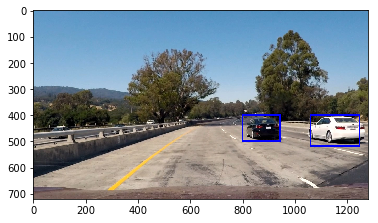

In [366]:
detect_img = cv2.imread(test_images[0])
detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
plt.imshow(process_img(detect_img))

In [280]:
detected = []
for imgfile in test_images:
    img = cv2.imread(imgfile)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected.append(process_img(img))

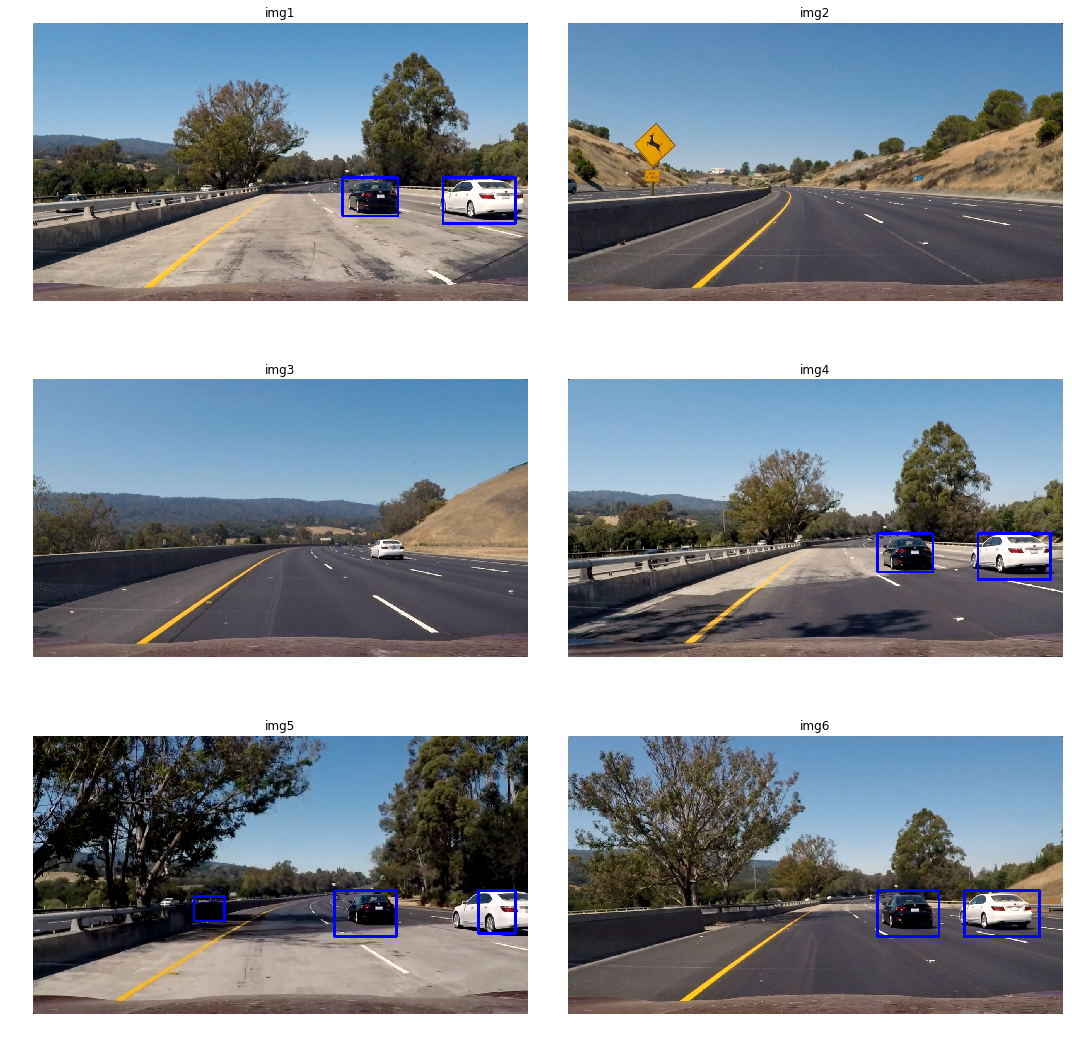

In [290]:
detected_titles = ['img1','img2','img3','img4','img5','img6']

visualize(detected, 3,2, titles = detected_titles, size=(15,15))
plt.tight_layout()
plt.savefig('./labeled_cars.png')

In [368]:
class Vehicle():
    
    def __init__(self):
        # Define wether the vehicle was detected or not.
        self.detected = False

        # Counts the number of times has been and hasn't been detected.
        self.n_detected = 0
        self.not_detected = 0

        # Used for the calculation of bounding boxes.
        self.nonzeroX = None
        self.nonzeroY = None

        # We track each detection using the centers, that are calculated, stored for following detections.
        self.Ycenter = None
        self.Xcenter = None
        self.recent_Ycenters = []
        self.recent_Xcenters = []

        # Width is used for template matching, we add the width and height to the top_left corner matched.
        self.width = None
        self.height = None
        self.recent_width = []
        self.recent_height = []

        # Dimensions of a bounding box, which are smoothed and used to draw a steady bounding box.
        self.top_left = None
        self.bottom_right = None

        # Save an image of the detected image for Template Matching
        self.template = None

        # A flag to indicate wether we need to perform Template matching for a Vehicle or not.
        self.flag = False   
        
    # Used to identify centers for each local detection.
    def centers(self):
        self.Ycenter = np.mean(self.nonzeroY)
        self.Xcenter = np.mean(self.nonzeroX)
    
    # Calculates the Car's dimensions using the detected bounding box.    
    def calc_dims(self):
        self.width = self.bottom_right[0] - self.top_left[0]
        self.height = self.bottom_right[1] - self.top_left[1]
    
    # A major function, it's main function is to calculate the top_left, bottom_right tuples for cv2.rectangle()
    def draw_window(self): 
        if ((len(self.recent_width) > 0) & (len(self.recent_height) > 0) &
            (len(self.recent_Ycenters) > 0) & (len(self.recent_Xcenters) > 0)):
            self.width = np.mean(self.recent_width)
            self.height = np.mean(self.recent_height)
            self.Xcenter = np.mean(self.recent_Xcenters)
            self.Ycenter = np.mean(self.recent_Ycenters)
            self.top_left = (np.int(self.Xcenter-self.width//2), np.int(self.Ycenter-self.height//2))
            self.bottom_right = (np.int(self.Xcenter+self.width//2), np.int(self.Ycenter+self.height//2))
        
    # Dequeue the array of saved dimensions, when it exceeds the specified n parameter
    def dequeue_dims(self, n=20):
        if len(self.recent_width) > n:
            self.recent_width.pop(0)
        if len(self.recent_height) > n:
            self.recent_height.pop(0)
    
    # Dequeue the array of saved centers, when it exceeds the specified n parameter
    def dequeue_centers(self, n=10):
        if len(self.recent_Ycenters) > n:
            self.recent_Ycenters.pop(0)
        if len(self.recent_Xcenters) > n:
            self.recent_Xcenters.pop(0)

In [349]:
# Match template function
def find_match(img, template, w, h):
    img_copy = np.copy(img)
    
    method = cv2.TM_CCOEFF_NORMED
    
    matched = cv2.matchTemplate(img_copy, template, method)
    _,_,_,max_loc = cv2.minMaxLoc(matched)

    top_left = max_loc
    x_max = np.minimum(max_loc[0]+w, img.shape[1])
    y_max = np.minimum(max_loc[1]+h, img.shape[0])
    bottom_right = (x_max,y_max)
    return top_left, bottom_right

In [350]:
# Global array that are manipulated by process_vid()
temp = []
cars = []

# Video Processing Pipeline
def process_vid(img):
    # INPUT RGB IMAGE
    '''
    1. Get Local Detections = local_detections
    2. Compare Local detections with previous detections ==> temp
    3. if past and present detections are similar append to ==> cars
    4. Compare cars with local_detections 
    5. if cars and local detection are the same ==> n_detected + 1
    6. else n_detected - 1
    7. If n_detected >= 3 draw
    8. if n_detected == 0 remove car
    '''
    global temp
    windows = []
    local_detections = []

    ## 1. Extract features
    windows.extend(detect_vehicle(img, clf=clf, scale=1., X_scaler=X_scaler, yrange=[400,528], color_space='YCrCb'))
    windows.extend(detect_vehicle(img, clf=clf, scale=1.25, X_scaler=X_scaler, yrange=[400,528], color_space='YCrCb'))
    windows.extend(detect_vehicle(img, clf=clf, scale=1.5, X_scaler=X_scaler, yrange=[400,656], color_space='YCrCb'))
    windows.extend(detect_vehicle(img, clf=clf, scale=2., X_scaler=X_scaler, yrange=[400,656], color_space='YCrCb'))
    
    ## 2. Generate Heatmap and Labels
    heatmap = generate_heatmap(img, windows, threshhold=30)
    labels = label(heatmap)
    
    ## 3. Loop over detected windows and append Vehicle instances into local_detection
    for window in range(1,labels[1]+1):
        vehicle = Vehicle()
        
        nonzero = (labels[0]==window).nonzero()
        vehicle.nonzeroY = nonzero[0]
        vehicle.nonzeroX = nonzero[1]
        
        vehicle.centers()
        
        vehicle.top_left = (np.min(vehicle.nonzeroX), np.min(vehicle.nonzeroY))
        vehicle.bottom_right = (np.max(vehicle.nonzeroX),np.max(vehicle.nonzeroY))
        
        vehicle.calc_dims()
        
        local_detections.append(vehicle)
    
    ## 4. Compare OLD detections in (temp) with NEW detections in (local_detections)
    if (len(temp) > 0):
        for car in temp:  
            for detection in local_detections:
                if (isclose(car.Ycenter, detection.Ycenter, abs_tol=2) &
                    isclose(car.Xcenter, detection.Xcenter, abs_tol=5)):
                # This means that both detections are quite similar which indicates an object.
                    car.top_left = np.int_(detection.top_left)
                    car.bottom_right = np.int_(detection.bottom_right)
                    car.width = car.bottom_right[0] - car.top_left[0]
                    car.height = car.bottom_right[1] - car.top_left[1]
                    
                    car.template = np.copy(img[car.top_left[1]:car.bottom_right[1],
                                               car.top_left[0]:car.bottom_right[0]])
                    
                    cars.append(car)
    
    ## 5. Loop over the detected Cars
    if len(cars) > 0:
        for car in cars:
            car.flag = False
            car.detected = False
            # i. Check in new detections if the car has been accurately detected (small abs_tol)
            for detection in local_detections:
                if (isclose(car.Ycenter, detection.Ycenter, abs_tol=10) & #10
                    isclose(car.Xcenter, detection.Xcenter, abs_tol=20)): #20

                    car.detected = True
                    
                    top_left = np.int_(np.maximum(detection.top_left, car.top_left))
                    bottom_right = np.int_(np.minimum(detection.bottom_right, car.bottom_right))

                    car.top_left = (top_left[0], top_left[1])
                    car.bottom_right = (bottom_right[0],bottom_right[1])
                    car.template = np.copy(img[car.top_left[1]:car.bottom_right[1],
                                               car.top_left[0]:car.bottom_right[0]]) 

                    car.recent_Xcenters.append(detection.Xcenter)
                    car.recent_Ycenters.append(detection.Ycenter)
                    car.dequeue_centers(n=5)

                    car.recent_width.append(detection.width)
                    car.recent_height.append(detection.height)
                    car.dequeue_dims(n=20)

                    car.draw_window()

                    car.Xcenter = detection.Xcenter
                    car.Ycenter = detection.Ycenter

                    local_detections.remove(detection)
                    
            # ii. Check if the car is loosly detected
                elif (isclose(car.Ycenter, detection.Ycenter, abs_tol=20) & #15
                      isclose(car.Xcenter, detection.Xcenter, abs_tol=50)): #30
                    # Set the car flag to True to search for this car using the find_match function()
                    car.flag = True
                    local_detections.remove(detection)
                    
            # iii. If car is loosly detected, search for a match and compare to previous centers
            if (car.n_detected >= 5 & car.flag==True):
                top_left, bottom_right = find_match(img, car.template, car.width, car.height)

                Xcenter = np.mean((top_left[0],bottom_right[0]))
                Ycenter = np.mean((top_left[1],bottom_right[1]))

                if (isclose(car.Ycenter, Ycenter, abs_tol=10) &
                    isclose(car.Xcenter, Xcenter, abs_tol=20)):
                ## Car is detected: Refresh all car properties except the template    
                    car.detected = True

                    car_top_left = (int(top_left[0]), int(top_left[1]))
                    car_bottom_right = (int(bottom_right[0]),int(bottom_right[1]))

                    car_Xcenter = np.mean((car_bottom_right[0], car_top_left[0]))
                    car_Ycenter = np.mean((car_bottom_right[1], car_top_left[1]))

                    car.recent_Xcenters.append(car_Xcenter)
                    car.recent_Ycenters.append(car_Ycenter)
                    car.dequeue_centers(n=5)

                    car_width = car_bottom_right[0] - car_top_left[0]
                    car_height = car_bottom_right[1] - car_top_left[1]

                    car.recent_width.append(car_width)
                    car.recent_height.append(car_height)
                    car.dequeue_dims(n=20)

                    car.draw_window()
                    
                    car.Xcenter = np.mean((car_Xcenter, car.Xcenter))
                    car.Ycenter = np.mean((car_Ycenter, car.Ycenter))
                    
                # iv. If no found is matched, draw a smoothed bounding box, but car.detected=False
                else:
                    car.dequeue_centers(n=2)
                    car.dequeue_dims(n=5)
                    car.draw_window()     
        
            if car.detected:
                car.n_detected += 1
                if car.not_detected > 0:
                    car.not_detected -= 1

            else:
                car.not_detected += 1

            # Draw the bounding box when we achieve a high certainity of the detected Vehicle
            if ((car.n_detected >= 5) & (car.not_detected < 3)):
                cv2.rectangle(img, car.top_left, car.bottom_right, (0,0,255), 6)
            
            # If we cannot detect the vehicle for 5 frames, remove it from cars to be re-detected.
            if (car.not_detected >= 5):
                cars.remove(car)    
    
    temp = local_detections.copy()
    
    return img

In [383]:
### Test the video processing pipeline using MoviePy Library
# Input Video
clip = VideoFileClip('./project_video.mp4')
# clip = VideoFileClip('./test_video.mp4')
# Output Video file name
clip_output = './project_final_output.mp4'
# Apply the process_vid() pipeline to the input video
format_clip = clip.fl_image(process_vid)
# Write the processed video onto the output file name
%time format_clip.write_videofile(clip_output, audio=False)
del clip
del format_clip